<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/C3VD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install -U --no-cache-dir gdown --pre

In [ ]:
import torch 
import sys
import os

pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip -q install fvcore iopath
!pip -q install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


import pytorch3d as p3d
print(p3d.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 MB 24.4 MB/s eta 0:00:00
0.7.2


In [ ]:
import gdown
import os
import cv2

video_url = 'https://drive.google.com/uc?id=1c_ewx6wts7pJTb3XVWVXEZLbFXDObpdP'
gdown.download(video_url,'SCARED_video.zip',quiet=True) 
if not os.path.exists('/content/SCARED_video/'):
    !unzip -q /content/SCARED_video.zip

video_pth = '/content/SCARED_video/d{}k{}_rgb.mp4'
frame_pth = '/content/SCARED_frames/d{}k{}_{:06d}.jpg'
if not os.path.isdir('/content/SCARED_frames'):
    !mkdir /content/SCARED_frames


for i in range(4):# 7 in total
  for j in range(4):
      cap = cv2.VideoCapture(video_pth.format(i+1, j+1)) 
      count = 0
      success = True
      while success:
        cap.set(cv2.CAP_PROP_POS_MSEC, (count * 1800))#1000 ms 1s
        success, image = cap.read()
        if success: 
           cv2.imwrite((frame_pth.format(i+1, j+1, count)), image[:1024,:,:], [int(cv2.IMWRITE_JPEG_QUALITY), 100]) #jpg_quality only left image
           count = count + 1
      print(video_pth[-14:-8].format(i+1, j+1), " {}frames  ".format(cap.get(cv2.CAP_PROP_FRAME_COUNT)), count)


d1k1  197.0frames   5
d1k2  280.0frames   7
d1k3  471.0frames   11
d1k4  0.0frames   0
d2k1  88.0frames   2
d2k2  1033.0frames   23
d2k3  1102.0frames   25
d2k4  2114.0frames   47
d3k1  329.0frames   8
d3k2  540.0frames   12
d3k3  448.0frames   10
d3k4  834.0frames   19
d4k1  728.0frames   17
d4k2  540.0frames   12
d4k3  407.0frames   10
d4k4  348.0frames   8


(<matplotlib.axes._subplots.AxesSubplot at 0x7f24b548db20>,
 <matplotlib.image.AxesImage at 0x7f24a71fbf70>)

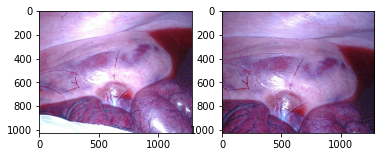

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

i1 = Image.open('/content/SCARED_frames/d2k1_000000.jpg')
i2 = Image.open('/content/SCARED_frames/d2k1_000001.jpg')
plt.subplot(121), plt.imshow(i1)
plt.subplot(122), plt.imshow(i2)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f24a7106ee0>,
 <matplotlib.image.AxesImage at 0x7f24a641d190>)

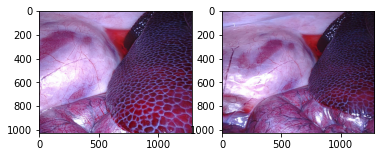

In [ ]:
i1 = Image.open('/content/SCARED_frames/d2k3_000000.jpg')
i2 = Image.open('/content/SCARED_frames/d2k3_000001.jpg')
plt.subplot(121), plt.imshow(i1)
plt.subplot(122), plt.imshow(i2)

d1k1  197.0frames   197
d1k2  280.0frames   280
d1k3  471.0frames   471
d1k4  0.0frames   0
d2k1  88.0frames   88
d2k2  1033.0frames   1033
d2k3  1102.0frames   1102
d2k4  2114.0frames   2114
d3k1  329.0frames   329
d3k2  540.0frames   540
d3k3  448.0frames   448
d3k4  834.0frames   834
d4k1  728.0frames   728
d4k2  540.0frames   540
d4k3  407.0frames   407
d4k4  348.0frames   348
d5k1  197.0frames   197
d5k2  1673.0frames   1673
d5k3  1440.0frames   1440
d5k4  411.0frames   411
d6k1  637.0frames   637
d6k2  1087.0frames   1087
d6k3  1573.0frames   1573
d6k4  1360.0frames   1360
d7k1  647.0frames   647
d7k2  628.0frames   628
d7k3  584.0frames   584
d7k4  2197.0frames   2197

all: 21893 frames

#loader

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from glob import glob
from PIL import Image
import numpy as np

os.chdir('/content')
class MyDataset(Dataset):
    def __init__(self, path_frame=None, transform=None):
        self.path_frame = path_frame
        self.transform = transform
        self.len = len(self.path_frame)

    def __len__(self):
      return len(self.path_frame)   

    def __getitem__(self, i):
        path_frame = self.path_frame[i]
        frame_idx = int(path_frame[-10:-4])
        img = Image.open(self.path_frame[i]).convert('RGB')
        try:  
          img_next = Image.open(path_frame.replace(path_frame[-10:-4], "{:06d}".format(frame_idx+1))).convert('RGB')
        except: 
          img_next = img
        if self.transform:
            img, img_next = self.transform(img), self.transform(img_next)
        return img, img_next

class AugmentImage(object):
    def __init__(self, augment_parameters):
        self.gamma_low = augment_parameters[0]  # 0.8
        self.gamma_high = augment_parameters[1]  # 1.2
        self.brightness_low = augment_parameters[2]  # 0.5
        self.brightness_high = augment_parameters[3]  # 2.0
        self.color_low = augment_parameters[4]  # 0.8
        self.color_high = augment_parameters[5]  # 1.2

    def __call__(self, sample):
        p = np.random.uniform(0, 1, 1)
        #if self.do_augmentation:
        if p > 0.5:
            # randomly shift gamma
            random_gamma = np.random.uniform(self.gamma_low, self.gamma_high)
            left_image_aug = sample ** random_gamma

            # randomly shift brightness
            random_brightness = np.random.uniform(self.brightness_low, self.brightness_high)
            left_image_aug = left_image_aug * random_brightness

            # randomly shift color
            random_colors = np.random.uniform(self.color_low, self.color_high, 3)
            for i in range(3):
                left_image_aug[i, :, :] *= random_colors[i]

            # saturate
            left_image_aug = torch.clamp(left_image_aug, 0, 1)

            sample = left_image_aug
        return sample

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

transform_train = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
    AugmentImage([0.8, 1.2, 0.5, 2.0, 0.8, 1.2]),
])

path_frames_all = glob('SCARED_frames/*.jpg') # 9459 from first 4 datasets
eighty_percent = int(0.8*len(path_frames_all))
path_frames_train = path_frames_all[:eighty_percent]
path_frames_valid = path_frames_all[eighty_percent:]
print('all:', len(path_frames_all),'train:', len(path_frames_train), 'valid:', len(path_frames_valid))

dataset_train = MyDataset(path_frame=path_frames_train, transform=transform_train)
dataset_valid = MyDataset(path_frame=path_frames_valid, transform=transform_train)


all: 216 train: 172 valid: 44


#model

In [ ]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# os.chdir('/content')
# if not os.path.isdir('monodepth2'):
#     !git clone https://github.com/nianticlabs/monodepth2.git
# %cd monodepth2
# import networks
# from utils import download_model_if_doesnt_exist
# from layers import transformation_from_parameters, rot_from_axisangle, get_translation_matrix, Project3D, BackprojectDepth, compute_depth_errors
# # from trainer import Trainer

# model_name = "mono_640x192"
# # model_name = 'mono_1024x320'
# # kitti weights path
# download_model_if_doesnt_exist(model_name)
# encoder_path = os.path.join("models", model_name, "encoder.pth")
# depth_decoder_path = os.path.join("models", model_name, "depth.pth")
# pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
# pose_decoder_path = os.path.join("models", model_name, "pose.pth")
# # MODEL
# depth_encoder = networks.ResnetEncoder(18, False)
# depth_decoder = networks.DepthDecoder(num_ch_enc=depth_encoder.num_ch_enc, scales=range(4))
# pose_encoder = networks.ResnetEncoder(18, "pretrained", 2)
# pose_decoder = networks.PoseDecoder(depth_encoder.num_ch_enc,1,2)#?, num_input_features, num_frames_to_predict_for
# # LOAD 
# # encoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/encoder_ssim.pth"))
# # depth_decoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/decoder_ssim.pth"))
# loaded_dict_enc = torch.load(encoder_path, map_location=device)
# filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in depth_encoder.state_dict()}
# depth_encoder.load_state_dict(filtered_dict_enc)
# depth_decoder.load_state_dict(torch.load(depth_decoder_path, map_location=device)) 
# pose_encoder.load_state_dict(torch.load(pose_encoder_path, map_location=device))
# pose_decoder.load_state_dict(torch.load(pose_decoder_path, map_location=device))

In [ ]:
# !pip -q install transformers
# from transformers import DPTFeatureExtractor, DPTForDepthEstimation

# feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
# depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

In [ ]:
os.chdir('/content')
!pip -q install einops
if not os.path.isdir('M3Depth'):
    !git clone https://github.com/br0202/M3Depth.git
%cd M3Depth
from loss import MonodepthLoss, ICPLoss
from models_resnet import Resnet18_md

m3depth_model = Resnet18_md(3)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.4 MB/s eta 0:00:00
Cloning into 'M3Depth'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 64 (delta 28), reused 30 (delta 11), pack-reused 0
Unpacking objects: 100% (64/64), 4.69 MiB | 7.32 MiB/s, done.
/content/M3Depth


In [ ]:
# monodepth 2D loss

In [ ]:
# warp mask, I_l meshgrid, D_r shift x grid, stack with y, I_l sampling

In [ ]:
# ICP

In [ ]:
import argparse
import sys
import torch

def adjust_learning_rate(optimizer, epoch, learning_rate):
    if epoch >= 30 and epoch < 40:
        lr = learning_rate / 2
    elif epoch >= 40:
        lr = learning_rate / 4
    else:
        lr = learning_rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description=' ')
    parser.add_argument('--lr', default=1e-5, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=18, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=18, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=50, type=int, help='epoch number')
    parser.add_argument('--startEpoch', type=int, default=0, help='epoch that start from')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='mse', help='total gpu')
    parser.add_argument('--applyICP', default=True, help="calculate ICP loss with or without applying masks")
    parser.add_argument('--ICPweight', type=float, default=1/1000, help='weights for ICP in the final loss')
    parser.add_argument('--focal_length', type=float, default=1135, help='mean focal length') 
    parser.add_argument('--baseline', type=float, help='baseline', default=4.2)
    parser.add_argument('--input_height', type=int, help='input height', default=256)
    parser.add_argument('--input_width', type=int, help='input width', default=320)
    parser.add_argument('--full_height', type=int, help='full height', default=1024)
    parser.add_argument('--full_width', type=int, help='full width', default=1280)
    
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

In [ ]:

def train(optimizer, models, loader, criterion, args):
    # if args.adjust_lr:
    #     adjust_learning_rate(optimizer, epoch, args.learning_rate)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_losses = []
    for model in models:
        model.train()
    for data in loader:

        left, right = data[0].to(device), data[1].to(device)
        disps = models[0](left)#.values()

        # feat = models[0](left)
        # outputs = models[1](feat) 
        # images_cat = torch.cat([left, right], 1)
        # feat = [models[2](inputs_cat)] # [torch.Size([1, 64, 128, 160]),torch.Size([1, 64, 64, 80]),torch.Size([1, 128, 32, 40]),torch.Size([1, 256, 16, 20]),torch.Size([1, 512, 8, 10]]
        # axisangle, translation = models[3](feat)
        # outputs.update({'axisangle': axisangle, 'translation': translation})
        loss = criterion[0](disps, [left, right])
        #### ICP####
        if args.applyICP:
            ICPLoss = args.ICPweight * criterion[1](disps, [left, right])
            loss = loss + ICPLoss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    return np.mean(train_losses)

def val(models, val_loader, criterion, applyICP, ICPweight):
    for model in models:
        model.eval()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    val_losses = []
    for data in val_loader:
      left, right = data[0].to(device), data[1].to(device)
      disps = models[0](left)#.values()
      # feat = models[0](left)
      # outputs = models[1](feat)
      # # disps = disps.values()
      loss = criterion[0](disps, [left, right])
      if applyICP:
          ICPLoss = ICPweight * criterion[1](disps, [left, right])
          loss = loss + ICPLoss
      val_losses.append(loss.item())
      return np.mean(val_losses)


In [ ]:
import time
import torch.optim as optim
os.chdir('/content')

def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed_everything()
    args = get_args()
    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    train_loader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=args.valid_batch_size, shuffle=False, num_workers=2)
    m3depth_model.to(device)
    # depth_encoder.to(device)
    # depth_decoder.to(device)
    models = []
    models.append(m3depth_model)
    # models.append(depth_encoder)
    # models.append(depth_decoder)

    K = np.array([[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00], # [[1.03530811e+03 0.00000000e+00 5.96955017e+02]
                  [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],#  [0.00000000e+00 1.03508765e+03 5.20410034e+02]
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=np.float32)
    inv_K = transforms.ToTensor()(np.linalg.pinv(K)).to(device)
    inv_K = inv_K.repeat(args.batch_size, 1, 1)#int(args.batch_size/2)
    T = np.eye(4, dtype=np.float32)
    T[0, 3] = -4.2 
    loss_2d = MonodepthLoss(n=4,SSIM_w=0.85,disp_gradient_w=0.1, lr_w=1).to(device)#(pred, [left, right])
    loss_3d = ICPLoss(args.focal_length,args.baseline,args.full_width,args.full_height,inv_K,T,applyMask=True)#(pred, [left, right])
    photometric_loss = loss_2d.to(device)
    geometric_loss = loss_3d.to(device)
    criterion = []
    criterion.append(photometric_loss)
    criterion.append(geometric_loss)
    parameters = []
    for model in models:
        parameters += list(model.parameters())
    # optimizer = optim.Adam([*model.parameters() for model in models], lr=args.lr)
    optimizer = optim.Adam(parameters, lr=args.lr)

    ICPLosses, running_val_loss, best_val_loss= 0, 0, np.inf
    running_val_loss = val(models, valid_loader, criterion, applyICP=args.applyICP, ICPweight=args.ICPweight)# running_val_loss /= self.val_n_img / self.args.batch_size
    print('Val_loss:', running_val_loss)
    
    for epoch in range(args.startEpoch, args.max_epochs):
        start = time.time()
        running_train_loss = train(optimizer, models, valid_loader, criterion, args)
        running_val_loss = val(models, valid_loader, criterion, applyICP=False, ICPweight=args.ICPweight)
        # Estimate loss per image
        # running_loss /= self.n_img / self.args.batch_size
        # running_val_loss /= self.val_n_img / self.args.batch_size
        print( 'Epoch:',epoch + 1,'train_loss:',running_train_loss,'val_loss:',running_val_loss,'time:',round(time.time() - start, 3),'s',)
        torch.save(models[0].state_dict(), 'weights/depth_encoder_border_last.pth')
        torch.save(models[1].state_dict(), 'weights/decoder_border_last.pth')
        torch.save(models[0].state_dict(), 'weights/encoder_epoch{}.pth'.format(str(epoch)) )
        torch.save(models[1].state_dict(), 'weights/decoder_epoch{}.pth'.format(str(epoch)) )
        torch.save({'epoch': epoch,
                    'encoder_model_state_dict': models[0].state_dict(),
                    'decoder_model_state_dict': models[1].state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_train_loss,
                    }, os.path.join('weights', 'weights_last.pt'))

        if running_val_loss < best_val_loss:
            torch.save(os.path.join(args.model_path, 'border_cpt.pth'))
            torch.save_continue_train(epoch, running_val_loss, 'weights_cpt.pt')
            best_val_loss = running_val_loss
            print('Model_saved')

    print('Finished Training.')
    # torch.save(os.path.join(models[0].state_dict(), 'weights', 'train_end.pth'))
    torch.save({'epoch': args.epochs,
                    'encoder_model_state_dict': models[0].state_dict(),
                    'decoder_model_state_dict': models[1].state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': running_val_loss,
                    }, os.path.join('weights', 'train_end.pt'))


#main

In [ ]:
if __name__ == "__main__":
    main()

Sample size- Train:172, Valid: 44
Val_loss: 2.7436916828155518


RuntimeError: ignored

# inference of 3

In [ ]:
# inference

import matplotlib.pyplot as plt

os.chdir('/content')
plt.subplot(251), plt.imshow(dataset_train[0][0].permute(1,2,0))
plt.subplot(256), plt.imshow(dataset_train[0][1].permute(1,2,0))
# # monodepth2
# feat = depth_encoder(dataset_train[0][0][None])
# pred = depth_decoder(feat)
# print(pred.keys())#[('disp', 3), ('disp', 2), ('disp', 1), ('disp', 0)]
# plt.subplot(252), plt.imshow(pred[('disp',0)][0][0].detach().cpu(), cmap='gray')
# feat = depth_encoder(dataset_train[0][0][None])
# pred = depth_decoder(feat)
# plt.subplot(257), plt.imshow(pred[('disp',0)][0][0].detach().cpu(), cmap='gray')
# #DPT
# image_raw = transforms.ToPILImage()(dataset_train[0][0])#[None]
# image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
# encoding = feature_extractor(image, return_tensors="pt")
# with torch.no_grad():
#     outputs = depth_estimation(**encoding)
#     print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
#     predicted_depth = outputs.predicted_depth
# prediction = torch.nn.functional.interpolate(
#     predicted_depth.unsqueeze(1),
#     size=image_raw.size[::-1],
#     mode="bicubic",
#     align_corners=False,
# ).squeeze()
# output = prediction.cpu().numpy() 
# plt.subplot(253), plt.imshow(output, cmap='gray')
# plt.subplot(258), plt.imshow(output, cmap='gray')
#M3Depth
disps = m3depth_model(dataset_train[0][0][None])
plt.subplot(254), plt.imshow(disps[0][0,0,:,:].detach().cpu(), cmap='gray')#[1, 2, 256, 320]
plt.subplot(259), plt.imshow(disps[0][0,1,:,:].detach().cpu(), cmap='gray')
disps = m3depth_model(dataset_train[0][1][None])
plt.subplot(255), plt.imshow(disps[0][0,0,:,:].detach().cpu(), cmap='gray')#[1, 2, 256, 320]
plt.subplot(2,5,10), plt.imshow(disps[0][0,1,:,:].detach().cpu(), cmap='gray')



#ICP

all: 70


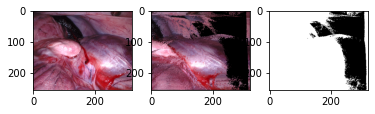

TypeError: ignored

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import torch.nn as nn
import torch
import torch.nn.functional as F
from pytorch3d.ops import iterative_closest_point
# from pytorch3d.loss import chamfer_distance

os.chdir('/content')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        # print(self.path_depth[i])
        if self.transform:
            img, depth = self.transform(img), self.transform(depth)
        return img, depth

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

path_test = glob('SCARED/*.tiff')
test_dataset = MyDataset(path_depth=path_test, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=2)
print('all:', len(path_test))


for data in test_loader:
    img, dep = data[0], data[1]
    scaled_images = [img]
    batch_size, _, h, w = img.size()
    K = np.array([[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00], # [[1.03530811e+03 0.00000000e+00 5.96955017e+02]
                  [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],#  [0.00000000e+00 1.03508765e+03 5.20410034e+02]
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=np.float32)
    inv_K = transforms.ToTensor()(np.linalg.pinv(K))#[1, 4, 4]
    inv_K = inv_K.repeat(batch_size, 1, 1)#[10, 4, 4]
    for i in range(3):
      ratio = 2**(i+1)
      scaled_images.append(nn.functional.interpolate(img, size=[h//ratio, w//ratio], mode='bilinear', align_corners=True))
    # def apply_disparity_for_ICP(self, img, disp): 
    x_base_ICP = torch.linspace(0, 1, w).repeat(batch_size, h, 1).type_as(img) #[10, 256, 320]
    y_base_ICP = torch.linspace(0, 1, h).repeat(batch_size, w, 1).transpose(1, 2).type_as(img) #[10, 256, 320]
    x_shifts_ICP = dep.squeeze(1)
    flow_field_ICP = torch.stack((x_base_ICP + x_shifts_ICP, y_base_ICP), dim=3)
    reconstruct_left = F.grid_sample(img, 2 * flow_field_ICP - 1, mode='bilinear', padding_mode='zeros')
    left_mask = [(torch.where(reconstruct_left[:, 0, :, :] == 0, torch.tensor(0), torch.tensor(1))).unsqueeze(1)]#reconstruct_left[0][:, 0, :, :] unscaled size
    # left_mask = F.interpolate(left_mask[0].float(), [imgHeight, imgWidth], mode="bilinear", align_corners=False)# 1024 1280
    
    plt.subplot(131), plt.imshow(img[9,:,:,:].permute(1,2,0))
    plt.subplot(132), plt.imshow(reconstruct_left[9,:,:,:].permute(1,2,0))
    plt.subplot(133), plt.imshow(left_mask[0][9,0,:,:], cmap='gray')#list of one tensor item[10, 1, 256, 320]
    plt.show()
    
    #def depth_to_pcl(self, depth, inv_K, applyMask, mask=None):
    meshgrid = np.meshgrid(range(w), range(h), indexing='xy')
    id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
    id_coords = nn.Parameter(torch.from_numpy(id_coords), requires_grad=False)
    ones = nn.Parameter(torch.ones(batch_size, 1, h * w), requires_grad=False)
    pix_coords = torch.unsqueeze(torch.stack([id_coords[0].view(-1), id_coords[1].view(-1)], 0), 0)
    pix_coords = pix_coords.repeat(batch_size, 1, 1)
    pix_coords = nn.Parameter(torch.cat([pix_coords, ones], 1), requires_grad=False)
    cam_points = torch.matmul(inv_K[:, :3, :3], pix_coords)#[10,3,3] [10, 3, 81920]
    cam_points = depth.view(batch_size, 1, -1) * cam_points
    cam_points = torch.cat([cam_points, ones], 1)
    pclLeft = cam_points
    
    #def compute_ICP_loss_with_MASK(self, pclLeft, pclRight):
    batchsize = pclLeft.shape[0]
    PCL_L = torch.zeros(batchsize, 3, 1000)
    PCL_R = torch.zeros(batchsize, 3, 1000)

    for item in range(batchsize):
        single_Left = pclLeft[item]
        filtered_pclLeft = single_Left[:3, single_Left[2, :] > 0]
        single_Right = pclRight[item]
        filtered_pclRight = single_Right[:3, single_Right[2, :] > 0]
        index = torch.randint(0, min(filtered_pclLeft.shape[1], filtered_pclRight.shape[1]), (1000,)).cuda()

        pcl_l = torch.index_select(filtered_pclLeft, 1, index)
        pcl_r = torch.index_select(filtered_pclRight, 1, index)
        PCL_L[item, :, :] = pcl_l
        PCL_R[item, : ,:] = pcl_r

        _, icploss, _, _, _ = iterative_closest_point(PCL_L.permute(0, 2, 1), PCL_R.permute(0, 2, 1))  # the second from last is RTs

        icploss = icploss.mean().to(pclLeft.device)
    # def compute_ICP_loss(self, pclLeft, pclRight):
    #     indexL = torch.randint(0, 1310720, (20000,)).cuda()
    #     indexR = torch.randint(0, 1310720, (20000,)).cuda()
    #     icploss , _ = chamfer_distance(torch.index_select(pclLeft.permute(0, 2, 1)[:, :, :3], 1, indexL),
    #                                    torch.index_select(pclRight.permute(0, 2, 1)[:, :, :3], 1, indexR))
    #     return icploss

In [ ]:
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
focal_length = 1135
baseline = 4.2
imgHeight = 1024
imgWidth = 1280
K = np.array([[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00], # [[1.03530811e+03 0.00000000e+00 5.96955017e+02]
                  [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],#  [0.00000000e+00 1.03508765e+03 5.20410034e+02]
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=np.float32)
inv_K = transforms.ToTensor()(np.linalg.pinv(K)).to(device)
inv_K = inv_K.repeat(1, 1, 1)#args.batch_size,1,1
T = np.eye(4, dtype=np.float32)
T[0, 3] = -4.2 

icp = ICPLoss(focal_length, baseline, 1024, 1280, inv_K, T, applyMask=True)#(pred, [left, right])
left, right = dataset_train[0][0][None].to(device), dataset_train[0][1][None].to(device)
disps = m3depth_model(left)
# icp_loss = icp(disps, [left, right]) # print(icp_loss)
# d 2 D
disp_left = disps[0][:, 0, :, :].unsqueeze(1)#[1, 2, 256, 320] 
disp_right = disps[0][:, 1, :, :].unsqueeze(1)
depth_left = focal_length * baseline / (disp_left * imgWidth)
depth_right = focal_length * baseline / (disp_right * imgWidth)
depth_left = F.interpolate(depth_left, [imgHeight, imgWidth], mode="bilinear", align_corners=False)
depth_right = F.interpolate(depth_right, [imgHeight, imgWidth], mode="bilinear", align_corners=False)
# rgbd scales
disp_left_est = [d[:, 0, :, :].unsqueeze(1) for d in disps]
disp_right_est = [d[:, 1, :, :].unsqueeze(1) for d in disps]
left_pyramid = self.MonodepthLoss.scale_pyramid(left, self.MonodepthLoss.n)
right_pyramid = self.MonodepthLoss.scale_pyramid(right, self.MonodepthLoss.n)
# generate_mask(disps, [left, right])
reconstruct_left = [self.apply_disparity_for_ICP(right_pyramid[i], -disp_left_est[i]) for i in range(self.MonodepthLoss.n)]
reconstruct_right = [self.apply_disparity_for_ICP(left_pyramid[i], disp_right_est[i]) for i in range(self.MonodepthLoss.n)]
left_mask = [(torch.where(reconstruct_left[0][:, 0, :, :] == 0, torch.tensor(0).cuda(), torch.tensor(1).cuda())).unsqueeze(1)]
right_mask = [(torch.where(reconstruct_right[0][:, 0, :, :] == 0, torch.tensor(0).cuda(), torch.tensor(1).cuda())).unsqueeze(1)]
left_mask = F.interpolate(left_mask[0].float(), [imgHeight, imgWidth], mode="bilinear", align_corners=False)
right_mask = F.interpolate(right_mask[0].float(), [imgHeight, imgWidth], mode="bilinear", align_corners=False)
# mask rgb D 2 point cloud
pcl_left = self.depth_to_pcl(depth_left, self.inv_K, self.applyMask, left_mask)  # depth_to_pcl should be changed with more parameters
pcl_right = self.depth_to_pcl(depth_right, self.inv_K, self.applyMask, right_mask)
# loss
ICPLoss = self.compute_ICP_loss_with_MASK(pcl_left, pcl_right)

#monodepth2

In [ ]:
# inference
os.chdir('/content')
images = [dataset_train[0][0], dataset_train[0][1]]
inputs_cat = torch.cat(images, 0)[None]
feat = [pose_encoder(inputs_cat)] # [torch.Size([1, 64, 128, 160]),torch.Size([1, 64, 64, 80]),torch.Size([1, 128, 32, 40]),torch.Size([1, 256, 16, 20]),torch.Size([1, 512, 8, 10]]
axisangle, translation = pose_decoder(feat)
mat_T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert=False)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.chdir('/content')
if not os.path.isdir('monodepth2'):
    !git clone https://github.com/nianticlabs/monodepth2.git
%cd monodepth2
import networks
from utils import download_model_if_doesnt_exist
from layers import transformation_from_parameters, rot_from_axisangle, get_translation_matrix, Project3D, BackprojectDepth, compute_depth_errors
# from trainer import Trainer

model_name = "mono_640x192"
# model_name = 'mono_1024x320'
# kitti weights path
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")
pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")
# MODEL
depth_encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=depth_encoder.num_ch_enc, scales=range(4))
pose_encoder = networks.ResnetEncoder(18, "pretrained", 2)
pose_decoder = networks.PoseDecoder(depth_encoder.num_ch_enc,1,2)#?, num_input_features, num_frames_to_predict_for
# LOAD 
# encoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/encoder_ssim.pth"))
# depth_decoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/decoder_ssim.pth"))
loaded_dict_enc = torch.load(encoder_path, map_location=device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in depth_encoder.state_dict()}
depth_encoder.load_state_dict(filtered_dict_enc)
depth_decoder.load_state_dict(torch.load(depth_decoder_path, map_location=device)) 
pose_encoder.load_state_dict(torch.load(pose_encoder_path, map_location=device))
pose_decoder.load_state_dict(torch.load(pose_decoder_path, map_location=device))


In [ ]:
# train
self.models = {}
self.parameters_to_train = []
self.models["encoder"] = networks.ResnetEncoder(self.opt.num_layers, self.opt.weights_init == "pretrained")
self.models["encoder"].to(self.device)
self.parameters_to_train += list(self.models["encoder"].parameters())
self.models["predictive_mask"] = networks.DepthDecoder(
                self.models["encoder"].num_ch_enc, self.opt.scales,
                num_output_channels=(len(self.opt.frame_ids) - 1))
self.models["predictive_mask"].to(self.device)
self.parameters_to_train += list(self.models["predictive_mask"].parameters())
self.model_optimizer = optim.Adam(self.parameters_to_train, self.opt.learning_rate)
self.model_lr_scheduler = optim.lr_scheduler.StepLR(self.model_optimizer, self.opt.scheduler_step_size, 0.1)

self.val_iter = iter(self.val_loader)

self.writers = {}
for mode in ["train", "val"]:
    self.writers[mode] = SummaryWriter(os.path.join(self.log_path, mode))        
self.backproject_depth = {}
self.project_3d = {}
for scale in self.opt.scales:
    h = self.opt.height // (2 ** scale)
    w = self.opt.width // (2 ** scale)
    self.backproject_depth[scale] = BackprojectDepth(self.opt.batch_size, h, w)
    self.backproject_depth[scale].to(self.device)

    self.project_3d[scale] = Project3D(self.opt.batch_size, h, w)
    self.project_3d[scale].to(self.device)

self.depth_metric_names = [ "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]


#def train(self):#Run the entire training pipeline
self.epoch = 0
self.step = 0
self.start_time = time.time()
for self.epoch in range(self.opt.num_epochs):
    self.run_epoch():#Run a single epoch of training and validation
        self.model_lr_scheduler.step()
        self.set_train()
        for batch_idx, inputs in enumerate(self.train_loader):
            before_op_time = time.time()
            #Pass a minibatch through the network and generate images and losses
            outputs, losses = self.process_batch(inputs)
            self.model_optimizer.zero_grad()
            losses["loss"].backward()
            self.model_optimizer.step()
            duration = time.time() - before_op_time
            # log less frequently after the first 2000 steps to save time & disk space
            early_phase = batch_idx % self.opt.log_frequency == 0 and self.step < 2000
            late_phase = self.step % 2000 == 0
            if early_phase or late_phase:
                self.log_time(batch_idx, duration, losses["loss"].cpu().data)
                if "depth_gt" in inputs:
                    self.compute_depth_losses(inputs, outputs, losses)
                self.log("train", inputs, outputs, losses)#Write an event to the tensorboard events file
                self.val():#Validate the model on a single minibatch
                    self.set_eval()
                    try:
                        inputs = self.val_iter.next()
                    except StopIteration:
                        self.val_iter = iter(self.val_loader)
                        inputs = self.val_iter.next()
                    with torch.no_grad():
                        outputs, losses = self.process_batch(inputs)
                        if "depth_gt" in inputs:
                            self.compute_depth_losses(inputs, outputs, losses)
                        self.log("val", inputs, outputs, losses)
                        del inputs, outputs, losses
                    self.set_train()
            self.step += 1        
    if (self.epoch + 1) % self.opt.save_frequency == 0:
        self.save_model()

In [ ]:
    def process_batch(self, inputs):
        """Pass a minibatch through the network and generate images and losses
        """
        for key, ipt in inputs.items():
            inputs[key] = ipt.to(self.device)

        # Otherwise, we only feed the image with frame_id 0 through the depth encoder
        features = self.models["encoder"](inputs["color_aug", 0, 0])
        outputs = self.models["depth"](features)

        # if self.opt.predictive_mask:
        #     outputs["predictive_mask"] = self.models["predictive_mask"](features)
        # if self.use_pose_net:
        outputs.update(self.predict_poses(inputs, features))

        self.generate_images_pred(inputs, outputs)
        losses = self.compute_losses(inputs, outputs)

        return outputs, losses

In [ ]:
    def compute_losses(inputs, outputs):
        """Compute the reprojection and smoothness losses for a minibatch
        """
        losses = {}
        total_loss = 0

        for scale in self.opt.scales:
            loss = 0
            reprojection_losses = []

            if self.opt.v1_multiscale:
                source_scale = scale
            else:
                source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]

            for frame_id in self.opt.frame_ids[1:]:
                pred = outputs[("color", frame_id, scale)]
                #Computes reprojection loss between a batch of predicted and target images
                reprojection_losses.append(self.compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)

            if not self.opt.disable_automasking:
                identity_reprojection_losses = []
                for frame_id in self.opt.frame_ids[1:]:
                    pred = inputs[("color", frame_id, source_scale)]
                    identity_reprojection_losses.append(
                        self.compute_reprojection_loss(pred, target))

                identity_reprojection_losses = torch.cat(identity_reprojection_losses, 1)

                if self.opt.avg_reprojection:
                    identity_reprojection_loss = identity_reprojection_losses.mean(1, keepdim=True)
                else:
                    # save both images, and do min all at once below
                    identity_reprojection_loss = identity_reprojection_losses

            elif self.opt.predictive_mask:
                # use the predicted mask
                mask = outputs["predictive_mask"]["disp", scale]
                if not self.opt.v1_multiscale:
                    mask = F.interpolate(
                        mask, [self.opt.height, self.opt.width],
                        mode="bilinear", align_corners=False)

                reprojection_losses *= mask

                # add a loss pushing mask to 1 (using nn.BCELoss for stability)
                weighting_loss = 0.2 * nn.BCELoss()(mask, torch.ones(mask.shape).cuda())
                loss += weighting_loss.mean()

            if self.opt.avg_reprojection:
                reprojection_loss = reprojection_losses.mean(1, keepdim=True)
            else:
                reprojection_loss = reprojection_losses

            if not self.opt.disable_automasking:
                # add random numbers to break ties
                identity_reprojection_loss += torch.randn(
                    identity_reprojection_loss.shape, device=self.device) * 0.00001

                combined = torch.cat((identity_reprojection_loss, reprojection_loss), dim=1)
            else:
                combined = reprojection_loss

            if combined.shape[1] == 1:
                to_optimise = combined
            else:
                to_optimise, idxs = torch.min(combined, dim=1)

            if not self.opt.disable_automasking:
                outputs["identity_selection/{}".format(scale)] = (
                    idxs > identity_reprojection_loss.shape[1] - 1).float()

            loss += to_optimise.mean()

            mean_disp = disp.mean(2, True).mean(3, True)
            norm_disp = disp / (mean_disp + 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss += self.opt.disparity_smoothness * smooth_loss / (2 ** scale)
            total_loss += loss
            losses["loss/{}".format(scale)] = loss

        total_loss /= self.num_scales
        losses["loss"] = total_loss
        return losses

# test dataset

In [ ]:
import matplotlib.pyplot as plt
import tifffile
from PIL import Image
import torchvision.transforms as transforms

import gdown
import os

depth_url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
gdown.download(depth_url,'SCARED.zip',quiet=True) 
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 
  
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),#torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]    
])
l = '/content/SCARED/d3k1_left_depth_map.tiff'
r = '/content/SCARED/d3k1_right_depth_map.tiff'
l_ = '/content/SCARED/d3k2_left_depth_map.tiff'
depth = tifffile.imread(l)[:,:,2]
depth_l = Image.fromarray(depth).convert('L')
depth = tifffile.imread(r)[:,:,2]
depth_r = transform_test(Image.fromarray(depth).convert('L'))
# depth_r = 1135 * 4.2 / (depth_r * 1240)
# depth_r = 1135 * 100 / (depth_r)
depth = tifffile.imread(l_)[:,:,2]
depth_r_ = Image.fromarray(depth).convert('L')
plt.subplot(231), plt.imshow(depth_l, cmap='gray')
plt.subplot(232), plt.imshow(depth_r[0], cmap='gray')
plt.subplot(233), plt.imshow(depth_r_, cmap='gray')


image_l = transform_test(Image.open(l.replace('left', 'Left')[:-14] + 'Image.png').convert('RGB'))
image_r = transform_test(Image.open(r.replace('right', 'Right')[:-14] + 'Image.png').convert('RGB'))
image_l_ = transform_test(Image.open(l_.replace('left', 'Left')[:-14] + 'Image.png').convert('RGB'))
plt.subplot(234), plt.imshow(image_l.permute(1,2,0))
plt.subplot(235), plt.imshow(image_r.permute(1,2,0))
plt.subplot(236), plt.imshow(image_l_.permute(1,2,0))

In [ ]:
!pip -q install -U --no-cache-dir gdown --pre

In [ ]:
import gdown
import os

depth_url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
gdown.download(depth_url,'SCARED.zip',quiet=True) 
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2

os.chdir('/content')

class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img, depth = self.transform(img), depth#self.transform(depth)
        return img, depth

#(1024, 1280, 3)
transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

path_test = glob('SCARED/*.tiff')
print('all:', len(path_test))

dataset_test = MyDataset(path_depth=path_test, transform=transform_test)
plt.subplot(121), plt.imshow(dataset_test[0].permute(1,2,0))#(dataset_test[0][0].permute(1,2,0)) ????????????????
plt.subplot(122), plt.imshow(dataset_test[0][1][0], cmap='gray')




def test(self):
    self.model.eval()

    ''' train on full endovis and test on Endovis test dataset keyframe'''
    if self.args.endovis_test_key:
    errors = []
    baseline = 4.2  # 5.045158438885819
    focal = 1135  # # 7866.0520212773545
    transform_resize = transforms.Resize((256, 320))
    with torch.no_grad():
        ground_truth_dir = '/disk_three/Dataset/Endovis_depth/TestKeyFrameOnly/depth'
        test_data_dir = '/disk_three/Dataset/Endovis_depth/TestKeyFrameOnly/image'
        image02_file = os.path.join(ground_truth_dir, 'image_02')
        image03_file = os.path.join(ground_truth_dir, 'image_03')
        for image in sorted(os.listdir(image02_file)):
            ground_truth_image_file_left = os.path.join(image02_file, image)
            ground_truth_image_file_right = os.path.join(image03_file, image)
            test_RGB_image_file_left = os.path.join(test_data_dir, 'image_02', image)
            test_RGB_image_file_right = os.path.join(test_data_dir, 'image_03', image)

            if not os.path.exists(ground_truth_image_file_left) and os.path.exists(
                    test_RGB_image_file_left):
                print('Error: point could not found - {}'.format(test_RGB_image_file_left))
            ''' Load in Input image '''
            left_input_image = pil.open(test_RGB_image_file_left).convert('RGB')
            left_input_image = transform_resize(left_input_image)
            right_input_image = pil.open(test_RGB_image_file_right).convert('RGB')
            left_input_image = transforms.ToTensor()(left_input_image).unsqueeze(0)
            right_input_image = transforms.ToTensor()(right_input_image).unsqueeze(0)
            left_input_image = left_input_image.to(self.device)
            right_input_image = right_input_image.to(self.device)
            ''' Load in grond truth'''
            depth_gt_left = pil.open(ground_truth_image_file_left).convert('L')
            depth_gt_left = np.asarray(depth_gt_left, dtype="float32")

            if np.sum(depth_gt_left > 0.1) < (0.1 * np.size(depth_gt_left)):
                print('abe == -1')
            else:
                disps = self.model(left_input_image)
                disps_upsample = F.interpolate(disps[0][:, 0, :, :].unsqueeze(1),
                                                [self.args.full_height, self.args.full_width], mode="bilinear",
                                                align_corners=False).squeeze().cpu().detach().numpy()
                depth_pred = (baseline * focal) / (disps_upsample * 1280)

            errors.append(compute_errors(depth_gt_left, depth_pred))
            mean_errors = np.array(errors).mean(0)

        #### 7 criteria ####
        print("\n  " + ("{:>8} | " * 7).format("abs_rel", "sq_rel", "rmse", "rmse_log", "a1", "a2", "a3"))
        print(("&{: 8.3f}  " * 7).format(*mean_errors.tolist()) + "\\\\")
        print("\n-> Done!")

# 3D reconstruction

In [ ]:
# rgbd
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(np.array(image_raw))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(depth_image.shape[0])
w = int(depth_image.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
# camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)#500, 500, 640,512
camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# rgbd intrin pcd
# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))  
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) 

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box() 
mesh_crop = mesh.crop(bbox)
gltf_path = f'./{img_path}.gltf'
o3d.io.write_triangle_mesh(gltf_path, mesh_crop, write_triangle_uvs=True)

# vid2depth main

In [ ]:
import math
import os
import random
import time
from absl import app
from absl import flags
from absl import logging
import model
import numpy as np
import tensorflow as tf
import util

gfile = tf.gfile

HOME_DIR = os.path.expanduser('~')
DEFAULT_DATA_DIR = os.path.join(HOME_DIR, 'vid2depth/data/kitti_raw_eigen')
DEFAULT_CHECKPOINT_DIR = os.path.join(HOME_DIR, 'vid2depth/checkpoints')

flags.DEFINE_string('data_dir', DEFAULT_DATA_DIR, 'Preprocessed data.')
flags.DEFINE_float('learning_rate', 0.0002, 'Adam learning rate.')
flags.DEFINE_float('beta1', 0.9, 'Adam momentum.')
flags.DEFINE_float('reconstr_weight', 0.85, 'Frame reconstruction loss weight.')
flags.DEFINE_float('smooth_weight', 0.05, 'Smoothness loss weight.')
flags.DEFINE_float('ssim_weight', 0.15, 'SSIM loss weight.')
flags.DEFINE_float('icp_weight', 0.0, 'ICP loss weight.')
flags.DEFINE_integer('batch_size', 4, 'The size of a sample batch')
flags.DEFINE_integer('img_height', 128, 'Input frame height.')
flags.DEFINE_integer('img_width', 416, 'Input frame width.')
# Note: Training time grows linearly with sequence length.  Use 2 or 3.
flags.DEFINE_integer('seq_length', 3, 'Number of frames in sequence.')
flags.DEFINE_string('pretrained_ckpt', None, 'Path to checkpoint with '
                    'pretrained weights.  Do not include .data* extension.')
flags.DEFINE_string('checkpoint_dir', DEFAULT_CHECKPOINT_DIR,
                    'Directory to save model checkpoints.')
flags.DEFINE_integer('train_steps', 200000, 'Number of training steps.')
flags.DEFINE_integer('summary_freq', 100, 'Save summaries every N steps.')
flags.DEFINE_bool('legacy_mode', False, 'Whether to limit losses to using only '
                  'the middle frame in sequence as the target frame.')
FLAGS = flags.FLAGS

# Maximum number of checkpoints to keep.
MAX_TO_KEEP = 100


def main(_):
  # Fixed seed for repeatability
  seed = 8964
  tf.set_random_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  if FLAGS.legacy_mode and FLAGS.seq_length < 3:
    raise ValueError('Legacy mode supports sequence length > 2 only.')

  if not gfile.Exists(FLAGS.checkpoint_dir):
    gfile.MakeDirs(FLAGS.checkpoint_dir)

  train_model = model.Model(data_dir=FLAGS.data_dir,
                            is_training=True,
                            learning_rate=FLAGS.learning_rate,
                            beta1=FLAGS.beta1,
                            reconstr_weight=FLAGS.reconstr_weight,
                            smooth_weight=FLAGS.smooth_weight,
                            ssim_weight=FLAGS.ssim_weight,
                            icp_weight=FLAGS.icp_weight,
                            batch_size=FLAGS.batch_size,
                            img_height=FLAGS.img_height,
                            img_width=FLAGS.img_width,
                            seq_length=FLAGS.seq_length,
                            legacy_mode=FLAGS.legacy_mode)

  train(train_model, FLAGS.pretrained_ckpt, FLAGS.checkpoint_dir,
        FLAGS.train_steps, FLAGS.summary_freq)


def train(train_model, pretrained_ckpt, checkpoint_dir, train_steps,
          summary_freq):
  """Train model."""
  if pretrained_ckpt is not None:
    vars_to_restore = util.get_vars_to_restore(pretrained_ckpt)
    pretrain_restorer = tf.train.Saver(vars_to_restore)
  vars_to_save = util.get_vars_to_restore()
  saver = tf.train.Saver(vars_to_save + [train_model.global_step],
                         max_to_keep=MAX_TO_KEEP)
  sv = tf.train.Supervisor(logdir=checkpoint_dir, save_summaries_secs=0,
                           saver=None)
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  with sv.managed_session(config=config) as sess:
    if pretrained_ckpt is not None:
      logging.info('Restoring pretrained weights from %s', pretrained_ckpt)
      pretrain_restorer.restore(sess, pretrained_ckpt)
    logging.info('Attempting to resume training from %s...', checkpoint_dir)
    checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    logging.info('Last checkpoint found: %s', checkpoint)
    if checkpoint:
      saver.restore(sess, checkpoint)

    logging.info('Training...')
    start_time = time.time()
    last_summary_time = time.time()
    steps_per_epoch = train_model.reader.steps_per_epoch
    step = 1
    while step <= train_steps:
      fetches = {
          'train': train_model.train_op,
          'global_step': train_model.global_step,
          'incr_global_step': train_model.incr_global_step
      }

      if step % summary_freq == 0:
        fetches['loss'] = train_model.total_loss
        fetches['summary'] = sv.summary_op

      results = sess.run(fetches)
      global_step = results['global_step']

      if step % summary_freq == 0:
        sv.summary_writer.add_summary(results['summary'], global_step)
        train_epoch = math.ceil(global_step / steps_per_epoch)
        train_step = global_step - (train_epoch - 1) * steps_per_epoch
        this_cycle = time.time() - last_summary_time
        last_summary_time += this_cycle
        logging.info(
            'Epoch: [%2d] [%5d/%5d] time: %4.2fs (%ds total) loss: %.3f',
            train_epoch, train_step, steps_per_epoch, this_cycle,
            time.time() - start_time, results['loss'])

      if step % steps_per_epoch == 0:
        logging.info('[*] Saving checkpoint to %s...', checkpoint_dir)
        saver.save(sess, os.path.join(checkpoint_dir, 'model'),
                   global_step=global_step)

      # Setting step to global_step allows for training for a total of
      # train_steps even if the program is restarted during training.
      step = global_step + 1

# C3VD

In [7]:
!wget http://drive.google.com/uc?export=view&id=1EsWdG3r9WYUpONzNKFbNVl_u9zpTQPCd

URL transformed to HTTPS due to an HSTS policy
--2023-01-23 08:19:00--  https://drive.google.com/uc?export=view
Resolving drive.google.com (drive.google.com)... 74.125.68.100, 74.125.68.102, 74.125.68.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.68.100|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2023-01-23 08:19:00 ERROR 400: Bad Request.



In [60]:
import gdown

gdown.download("https://drive.google.com/uc?export=view&id=1nn4t7vPaZb5iKxg9UqoAG0lQXE1Co66e&confirm=t", 'cecum_t1_a.zip', quiet=True)
if not os.path.isdir('c1v1'):
    !unzip cecum_t1_a

In [ ]:
gdown.download("http://drive.google.com/uc?export=view&id=1EsWdG3r9WYUpONzNKFbNVl_u9zpTQPCd", 'ascend_colon.obj', quiet=True)

gdown.download("http://drive.google.com/uc?export=view&id=1ZYpT3aXKlpcW4kr_Qfa7dT9S_OPrMPPQ", 'cecum_t1_a_mold.zip', quiet=True)
if not os.path.isdir('/content/ascend_mold_under_review'):
    !unzip cecum_t1_a_mold.zip
top = "/content/ascend_mold_under_review/ascend_mold_top.stl"
core = top.replace('top', 'core')
core = top.replace('top', 'bottom')

In [ ]:
gdown.download("http://drive.google.com/uc?export=view&id=18m3Z5zJtljor_AGmPW8OgO9fRuactuNk&confirm=t", 'full_colon_t1.zip', quiet=True)
if not os.path.isdir('/content/seq1'):
    !unzip full_colon_t1.zip

In [ ]:
!unzip full_colon_t1

In [6]:
import torch
import sys

# We try to install PyTorch3D via a released wheel.
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip -q install fvcore iopath
!pip -q install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 550.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 MB 11.3 MB/s eta 0:00:00


<p float="left">
<img src='https://durr.jhu.edu/wp-content/uploads/2022/06/2022-C3VD_ex.png' height=150>
</p>

In [139]:
path_obj = glob('c1v1/*.obj')#ground truth triangulated mesh
print(path_obj, len(path_obj))#'c1v1/outputMesh.obj'

['c1v1/outputMesh.obj'] 1


In [140]:
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
import os

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
trg_obj = os.path.join('c1v1/outputMesh.obj')
verts, faces, aux = load_obj(trg_obj)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# center = verts.mean(0)
# verts = verts - center
# scale = max(verts.abs().max(0)[0])
# verts = verts / scale

trg_mesh = Meshes(verts=[verts], faces=[faces_idx])

/usr/local/lib/python3.8/dist-packages/pytorch3d/io/obj_io.py:542: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


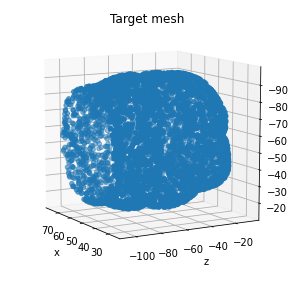

In [141]:
from pytorch3d.ops import sample_points_from_meshes
import matplotlib.pyplot as plt

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    ax = plt.figure(figsize=(5, 5)).add_subplot(projection='3d')
    # ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

plot_pointcloud(trg_mesh, "Target mesh")




In [ ]:

deform_verts = torch.full(trg_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)
# Number of optimization steps
Niter = 2000
# Weight for the chamfer loss
w_chamfer = 1.0 
# Weight for mesh edge loss
w_edge = 1.0 
# Weight for mesh normal consistency
w_normal = 0.01 
# Weight for mesh laplacian smoothing
w_laplacian = 0.1 
# Plot period for the losses
plot_period = 250
loop = tqdm(range(Niter))


40146


(<matplotlib.axes._subplots.AxesSubplot at 0x7f46c6488d60>,
 <matplotlib.image.AxesImage at 0x7f46c646af10>)

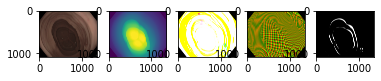

In [58]:
from PIL import Image
import numpy as np
# import tifffile
import gdal

color = Image.open('/content/c1v1/1_color.png')
depth = gdal.Open('/content/c1v1/1_depth.tiff').ReadAsArray()# (1080, 1350)
normals = gdal.Open('/content/c1v1/1_normals.tiff').ReadAsArray().transpose(1,2,0)# (3, 1080, 1350)
flow = gdal.Open('/content/c1v1/1_flow.tiff').ReadAsArray().transpose(1,2,0)# (3, 1080, 1350)
print(flow.max())
flow = Image.fromarray((flow*255).astype(np.uint8))
occlusion = Image.open('/content/c1v1/1_occlusion.png').convert('RGB')
plt.subplot(251), plt.imshow(color)
plt.subplot(252), plt.imshow(depth)
plt.subplot(253), plt.imshow(normals)
plt.subplot(254), plt.imshow(flow)
plt.subplot(255), plt.imshow(occlusion)

['c1v1/pose.txt'] 1
(276, 4, 4)
[[ 9.51413e-01 -3.05922e-01 -3.50054e-02  5.01618e+01]
 [ 3.07538e-01  9.38425e-01  1.57415e-01  5.38985e+01]
 [-1.53069e-02 -1.60533e-01  9.86912e-01 -6.83439e+01]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.00000e+00]] 0.986912384561


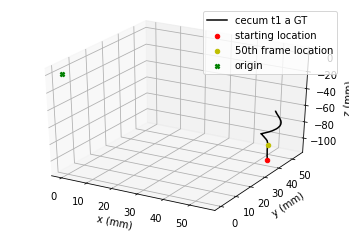

In [142]:
from glob import glob
from google.colab import files
import matplotlib.pyplot as plt

path_txt = glob('c1v1/*.txt')# homogenous pose (flattened in row-major order)
print(path_txt, len(path_txt))#'c1v1/pose.txt'
# files.download('seq1/pose.txt')

with open('c1v1/pose.txt') as f:
    lines = f.readlines()#list of 276 items
poses_list = []
for line in lines:
    a = line.strip().split(',')
    pose = np.array(line.strip().split(',')).reshape(4,4).astype(float)# Strips the newline character
    poses_list.append(pose)
poses_arr = np.array(poses_list)
print(poses_arr.shape)
print(poses_arr[275], np.linalg.det(poses_list[275][:2,:2]))

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlabel("x (mm)")
ax.set_ylabel("y (mm)")
ax.set_zlabel("z (mm)")
ax.scatter(poses_arr[0, 0, 3], poses_arr[0, 1, 3], zs=poses_arr[0, 2, 3], c='r', label='starting location') #, zdir='y'
ax.scatter(poses_arr[50, 0, 3], poses_arr[50, 1, 3], zs=poses_arr[50, 2, 3], c='y', label='50th frame location') #, zdir='y'
ax.scatter(0, 0, zs=0, c='g', label='origin', marker='X') #, zdir='y'
figure1, = ax.plot(poses_arr[:, 0, 3], poses_arr[:, 1, 3], poses_arr[:, 2, 3], c='k', label='cecum t1 a GT')#, zdir='z'
# figure2, = ax.plot(pred_points[:, 0, 0], pred_points[:, 1, 0], pred_points[:, 2, 0], c='b', label=index2+' GT')
ax.legend()
plt.savefig('poses.png')
plt.show()

In [92]:
path_tiff = glob('c1v1/*_depth.tiff')
print(len(path_tiff))

276
